In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, confusion_matrix

# Load MNIST Dataset

* Use mnist from PyTorch only for preparing dataset (since it is faster than sklearn library...)

In [2]:
"""
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
X = mnist.data.astype('float32')
y = mnist.target.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)
"""
# YOU CAN REMOVE COMMENT ABOVE TO USE SKLEARN LIBRARY FOR LOADING MNIST DATASET

def load_MNIST():
    from torchvision import datasets
    mnist_train = datasets.MNIST(root = './datasets/', train=True, download=False)
    mnist_test  = datasets.MNIST(root = './datasets/', train=False, download=False)
    return mnist_train, mnist_test

# Data Loading
trainset, testset = load_MNIST()
X_train, y_train = trainset.data.numpy(), trainset.targets.numpy()
X_test, y_test   = testset.data.numpy(), testset.targets.numpy()

# Data Normalization
X_train = X_train/255
X_test  = X_test/255

print(f"X_TRAIN SHAPE: {X_train.shape}, Y_TRAIN SHAPE: {y_train.shape}")
print(f" X_TEST SHAPE: {X_test.shape},  Y_TEST SHAPE: {y_test.shape}")

X_TRAIN SHAPE: (60000, 28, 28), Y_TRAIN SHAPE: (60000,)
 X_TEST SHAPE: (10000, 28, 28),  Y_TEST SHAPE: (10000,)


# DATA VISUALIZATION

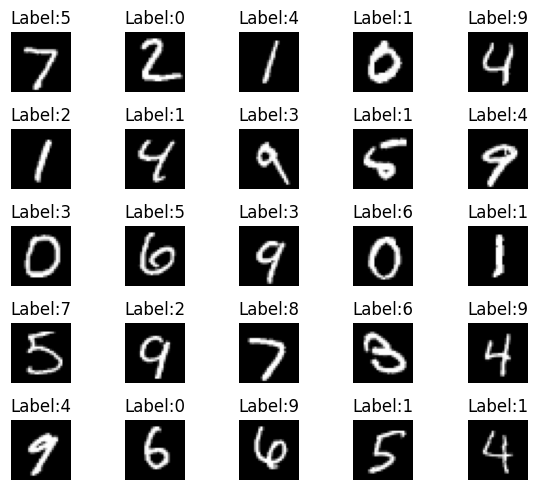

In [3]:
plt.figure(figsize=(6,5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f'Label:{y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# PCA based Classifier

In [4]:
class PCA_Classifier(object):
    def __init__(self, n_component=784, n_class=10, vec_len=28*28):
        self.vec_len        = vec_len
        self.n_class        = n_class
        self.n_component    = n_component
        self.svd            = TruncatedSVD(n_components=vec_len)
        self.means          = [0 for _ in range(self.n_class)]
        self.pca_components = {label:None for label in range(self.n_class)}
    
    def set_n_components(self, n_component):
        self.n_component = n_component
    
    def fit(self, X, y, zero_mean=True):
        for label in range(self.n_class):
            indices = np.where(y==label)    
            X0 = X[indices].reshape(-1, self.vec_len)
            self.means[label] = np.mean(X0, axis=0) if zero_mean else 0
            X0 = X0 - self.means[label]
            self.svd.fit(X0)
            self.pca_components[label] = self.svd.components_
            
    def predict(self, X):
        reconstructed_X = {}
        for label in range(self.n_class):
            svd = TruncatedSVD(n_components=self.n_component)
            svd.components_ = self.pca_components[label][:self.n_component]
            reconstructed_X[label] = svd.inverse_transform(svd.transform(X.reshape(-1, self.vec_len)-self.means[label]))
        self.pred = []
        for i in range(len(X_test)):
            min_distance = float('inf')
            predicted_digit = None
            for digit in range(10):
                distance = np.linalg.norm(X_test[i].reshape(-1)-self.means[digit] - reconstructed_X[digit][i])
                if distance < min_distance:
                    min_distance = distance
                    predicted_digit = digit
            self.pred.append(predicted_digit)
        return self.pred
    

In [5]:
clf = PCA_Classifier()
clf.fit(X_train, y_train, zero_mean=False)
n_components = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
accuracies = []
for n_component in n_components:
    clf.set_n_components(n_component)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"Number of components={n_component:3>}, Accuracy: {acc*100:.2f}%")
    accuracies.append(acc)

Number of components=1, Accuracy: 86.81%
Number of components=2, Accuracy: 89.17%
Number of components=4, Accuracy: 92.12%
Number of components=8, Accuracy: 94.57%
Number of components=16, Accuracy: 95.40%
Number of components=32, Accuracy: 95.77%
Number of components=64, Accuracy: 94.43%
Number of components=128, Accuracy: 92.08%
Number of components=256, Accuracy: 86.26%
Number of components=512, Accuracy: 49.56%


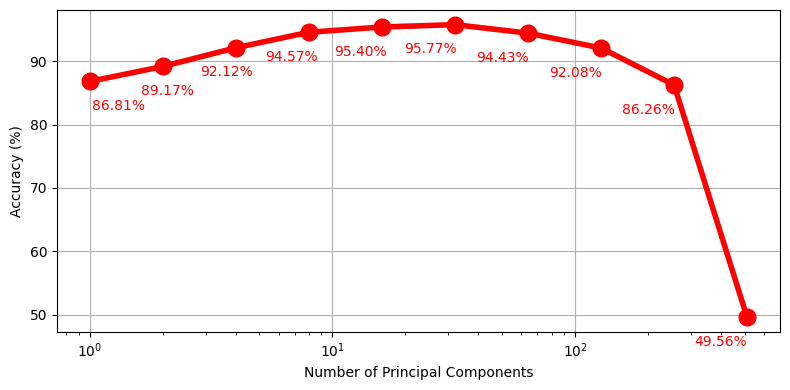

In [6]:
plt.figure(figsize=(8,4))
plt.plot(n_components, np.array(accuracies)*100, marker='o', color='red', markersize=12, linewidth=4)
plt.xscale('log')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy (%)')
plt.grid(True)
for i, txt in enumerate(accuracies):
    plt.text(n_components[i]+np.log(2), accuracies[i] * 100 - 5, f'{accuracies[i]*100:.2f}%', ha='right', va='bottom', color='red')
plt.tight_layout()
plt.show()

In [7]:
clf.set_n_components(32)
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
conf_mat = confusion_matrix(y_test, pred)
acc_conf_mat = (conf_mat/np.sum(conf_mat, axis=1))*100
acc_conf_mat = np.round(acc_conf_mat, 2)

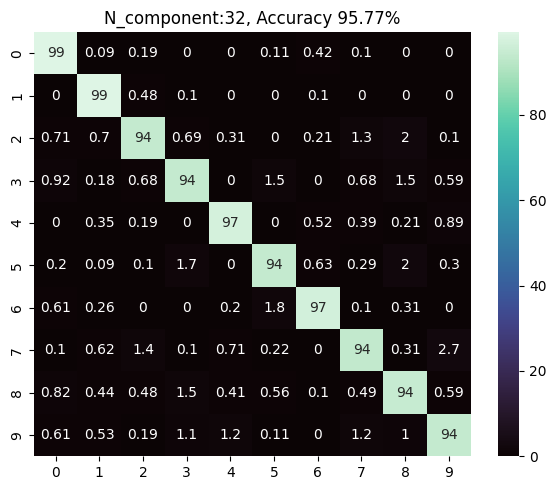

In [8]:
plt.figure(figsize=(6,5))
sns.heatmap(acc_conf_mat, cmap='mako', annot=True)
plt.title(f"N_component:{clf.n_component}, Accuracy {acc*100:.2f}%")
plt.tight_layout()
plt.show()

In [9]:
reconstructed_X = [[] for _ in range(clf.n_class)]
for idx in range(5):
    for label in range(clf.n_class):
        svd = TruncatedSVD(n_components=clf.n_component)
        svd.components_ = clf.pca_components[label][:clf.n_component]
        reconstructed_X[label].append(svd.inverse_transform(svd.transform(X_test[idx].reshape(-1, clf.vec_len)-clf.means[label])))

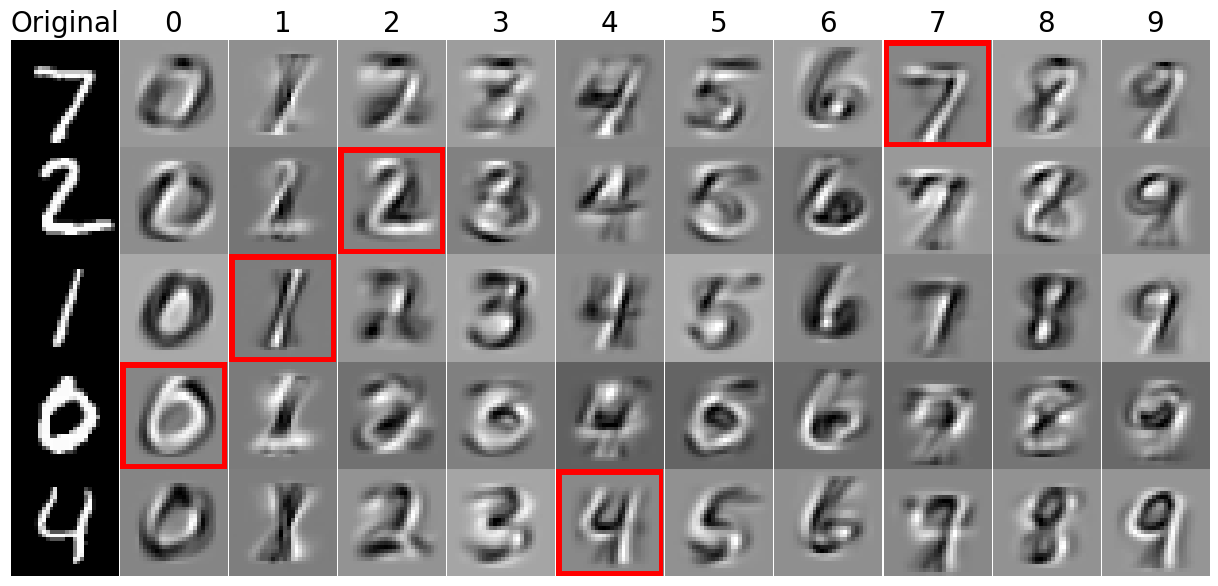

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(5,11,1)
plt.imshow(X_test[0], cmap='gray')
plt.title(f"Original", fontsize=20)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0.33, right = 1, top = 1, hspace = 0, wspace = 0)
for jdx in range(5):
    for idx, img in enumerate(reconstructed_X):
        plt.subplot(5,11,jdx*10+idx+(jdx+2))
        plt.imshow(img[jdx].reshape(28,28), cmap='gray')
        plt.axis('off')
        plt.xticks([]), plt.yticks([])
        plt.subplots_adjust(left = 0, bottom = 0.33, right = 1, top = 1, hspace = 0, wspace = 0)
        if jdx==0:
            plt.title(f"{idx}", fontsize=20)
        if idx == y_test[jdx]:
            current_ax = plt.gca()  # 현재 subplot의 축 가져오기
            rect = patches.Rectangle((0, 0), 27, 27, linewidth=5, edgecolor='red', facecolor='none')
            current_ax.add_patch(rect)  # 네모 테두리 추가
    if (jdx+1)*10+(jdx+2) < 56:
        plt.subplot(5,11,(jdx+1)*10+(jdx+2))
        plt.imshow(X_test[jdx+1], cmap='gray')
        plt.xticks([]), plt.yticks([])
        plt.axis('off')
        plt.subplots_adjust(left = 0, bottom = 0.33, right = 1, top = 1, hspace = 0, wspace = 0)
# plt.tight_layout()
plt.show()